# Transcription factor activity inference

## Load packages

We need to load the relevant packages, scanpy to handle scRNA-seq data and decoupler to use statistical methods.

In [65]:
import scanpy as sc
import decoupler as dc


# Only needed for processing
import numpy as np
import pandas as pd

# Needed for some plotting
import matplotlib.pyplot as plt

### Motivation: 

scRNA-seq yields many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from our trascriptomics data from prior knowledge.

In this notebook we showcase how to use decoupler for transcription factor (TF) and pathway enrichment from a human data-set. The data consists of ~5k Blood myeloid cells from healthy and COVID-19 infected patients available in the Single Cell Expression Atlas [here](https://www.ebi.ac.uk/gxa/sc/experiments/E-MTAB-9221/results/tsne?plotType=umap&plotOption=20).


For the TF activity inference analysis we will need a) a gene regulatory network (GRN) and b) a statistical method.

a) **Gene Regulatory Network(GRN)**: 

[CollecTRI](https://github.com/saezlab/CollecTRI) is a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. This collection provides an increased coverage of transcription factors and a superior performance in identifying perturbed TFs compared to our previous [DoRothEA](https://saezlab.github.io/dorothea/) network and other literature based GRNs. Similar to DoRothEA, interactions are weighted by their mode of regulation (activation or inhibition).

For this example we will use the human version (mouse and rat are also available). We can use `decoupler` to retrieve it from `omnipath`. The argument `split_complexes` keeps complexes or splits them into subunits, by default we recommend to keep complexes together.

Note! : In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as CellOracle, pySCENIC or SCENIC+.




<div class="alert alert-info">

**Note**

In this tutorial we use the network CollecTRI, but we could use any other GRN coming from an inference method such as [CellOracle](https://morris-lab.github.io/CellOracle.documentation/), [pySCENIC](https://pyscenic.readthedocs.io/en/latest/) or [SCENIC+](https://scenicplus.readthedocs.io/en/latest/). </div>

In [15]:
# Retrieve CollecTRI gene regulatory network
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [16]:
collectri.head()

,source,target,weight,PMID
0,MYC,TERT,1,10022128;10491298;10606235;10637317;10723141;1...
1,SPI1,BGLAP,1,10022617
2,SMAD3,JUN,1,10022869;12374795
3,SMAD4,JUN,1,10022869;12374795
4,STAT5A,IL2,1,10022878;11435608;17182565;17911616;22854263;2...


**b) Activity inference with Univariate Linear Model (ULM)**




To infer TF enrichment scores we will run the Univariate Linear Model (`ulm`) method. For each sample in our dataset (`mat`) and each TF in our network (`net`), it fits a linear model that predicts the observed gene expression based solely on the TF’s TF-Gene interaction weights. Once fitted, the obtained t-value of the slope is the score. If it is positive, we interpret that the TF is active and if it is negative we interpret that it is inactive.

<img src="scverse-tutorials/docs/notebooks/img/ulm.png"/>




## Load data

In [63]:
#First import results from previous DEA tutorial with DEseq2
results_df = pd.read_csv("T_cell_DEA_pyDeseq2_results_df.csv",index_col=0)
results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
A1BG,70.471700,-0.082879,0.183383,-0.876097,0.380977,0.719800
A2M,36.735027,-1.071370,0.338611,-3.848842,0.000119,0.006269
A2MP1,15.628274,0.032486,0.289659,0.802367,0.422340,0.748127
AAAS,18.305878,0.040930,0.244828,0.593935,0.552555,0.827623
AACS,24.630203,0.060574,0.231249,0.754344,0.450643,0.766366
...,...,...,...,...,...,...
ZXDC,30.181501,-0.080694,0.225169,-0.963323,0.335385,0.687688
ZYG11B,101.884620,0.065714,0.231680,0.827915,0.407719,0.738730
ZYX,81.599910,0.153035,0.187370,1.448655,0.147434,0.487976


From the DEA results above, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used, but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value. We will transform the obtained t-values stored in `stats` to a wide matrix so that it can be used by decoupler:


In [47]:
#from the DEA results above, we can use the obtained gene level statistics to perform enrichment analysis. Any statistic can be used, but we recommend using the t-values instead of logFCs since t-values incorporate the significance of change in their value. We will transform the obtained t-values stored in stats to a wide matrix so that it can be used by decoupler:
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})
mat

gene_symbol,A1BG,A2M,A2MP1,AAAS,AACS,AAGAB,AAK1,AAMDC,AAMP,AAR2,...,ZUP1,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
T cell,-0.876097,-3.848842,0.802367,0.593935,0.754344,-0.227301,-0.61717,0.294581,1.39611,0.505238,...,1.56492,1.396946,3.544967,-1.017032,-2.251387,-0.963323,0.827915,1.448655,0.122474,-0.248011


We can run `ulm` with a one-liner:

In [50]:
# Infer pathway activities with ulm
tf_acts, tf_pvals = dc.run_ulm(mat=mat, net=collectri)
tf_acts

,ABL1,AHR,AIRE,AP1,APEX1,AR,ARID3B,ARID4A,ARID5B,ARNT,...,ZNF350,ZNF354C,ZNF362,ZNF382,ZNF384,ZNF395,ZNF436,ZNF699,ZNF76,ZNF91
T cell,0.670022,0.77803,-1.94135,-1.628783,0.366503,-0.427226,-0.325884,0.013003,0.410143,-0.868288,...,0.321947,-1.824237,1.113136,0.218782,-1.44051,0.845993,0.294943,-0.835089,1.839208,-2.407625


Let us plot the obtained scores for the top active/inactive transcription factors:

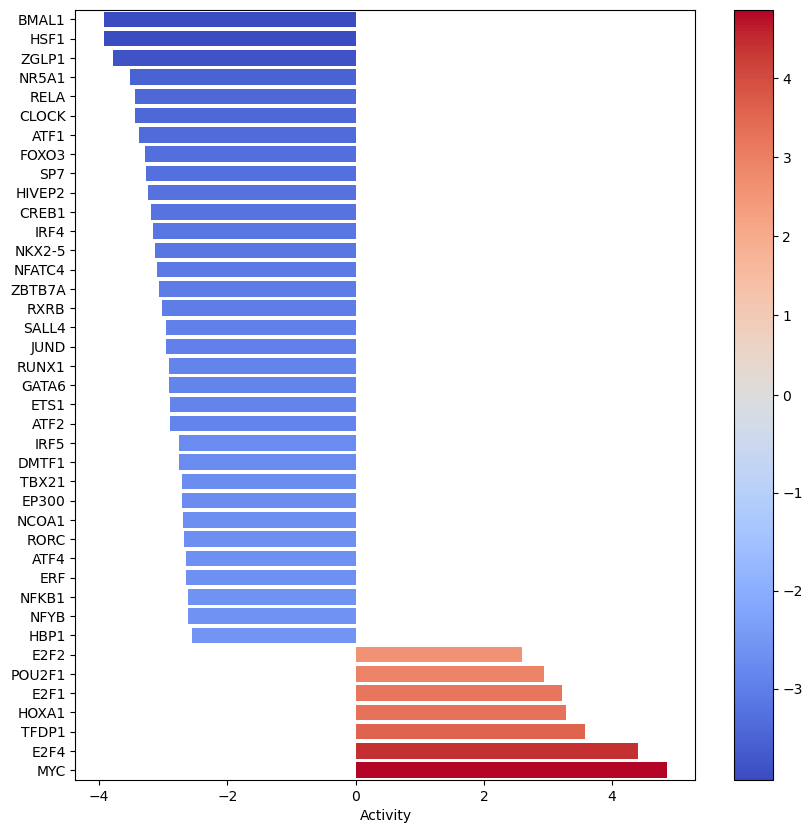

In [61]:
dc.plot_barplot(tf_acts, 'T cell', top=40, vertical=True,figsize=[10,10])

In accordance to the previous pathway results, T cells seem to activate for TFs responsible for cell growth (E2F4, TFDP1, E2F1).

Like with pathways, we can explore how the target genes look like:

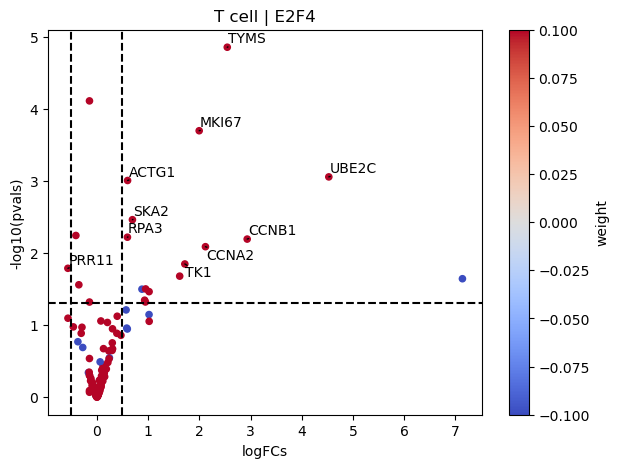

In [62]:
# Extract logFCs and pvals
logFCs = results_df[['log2FoldChange']].T.rename(index={'log2FoldChange': 'T cell'})
pvals = results_df[['padj']].T.rename(index={'padj': 'T cell'})

# Plot
dc.plot_volcano(logFCs, pvals, 'T cell', name='E2F4', net=collectri, top=10, sign_thr=0.05, lFCs_thr=0.5)

# Load packages

First, we need to load the relevant packages, scanpy to handle scRNA-seq data and decoupler to use statistical methods. We also need to load `mat` from earlier.

In [2]:
results_df = pd.read_csv("./data/T_cell_DEA_pyDeseq2_results_df.csv", index_col="gene_symbol")
mat = results_df[['stat']].T.rename(index={'stat': 'T cell'})

## Pathway

Another analysis we can perform is to infer pathway activities from our transcriptomics data.

## PROGENy model

[PROGENy](https://saezlab.github.io/progeny/) is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

* **Androgen**: involved in the growth and development of the male reproductive organs.

* **EGFR**: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

* **Estrogen**: promotes the growth and development of the female reproductive organs.

* **Hypoxia**: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

* **JAK-STAT**: involved in immunity, cell division, cell death, and tumor formation.

* **MAPK**: integrates external signals and promotes cell growth and proliferation.

* **NFkB**: regulates immune response, cytokine production and cell survival.

* **p53**: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

* **PI3K**: promotes growth and proliferation.

* **TGFb**: involved in development, homeostasis, and repair of most tissues.

* **TNFa**: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

* **Trail**: induces apoptosis.

* **VEGF**: mediates angiogenesis, vascular permeability, and cell migration.

* **WNT**: regulates organ morphogenesis during development and tissue repair.

To access it we can use `decoupler`.

In [3]:
# Retrieve PROGENy model weights
progeny = dc.get_progeny(top=500)
progeny

  File "/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
  File "/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 181, in _download
    resp.raise_for_status()
  File "/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 500 Server Error: Internal Server Error for url: https://omnipathdb.org/queries/enzsub?format=json

  File "/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 143, in maybe_download
    res = self._download(req)
  File "/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/omnipath/_core/downloader/_downloader.py", line 181, in _download
    resp.raise_for_

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


## Activity inference with Multivariate Linear Model (MLM)

To infer pathway enrichment scores we will run the Multivariate Linear Model (`mlm`) method. For each sample in our dataset (`adata`), it fits a linear model that predicts the observed gene expression based on all pathways’ Pathway-Gene interactions weights. Once fitted, the obtained t-values of the slopes are the scores. If it is positive, we interpret that the pathway is active and if it is negative we interpret that it is inactive.

<img src="img/mlm.png"/>

We can run `mlm` with a one-liner:

In [4]:
# Infer pathway activities with mlm
pathway_acts, pathway_pvals = dc.run_mlm(mat=mat, net=progeny)
pathway_acts

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
T cell,-0.561211,1.116455,1.701393,-5.912141,8.3318,-0.631677,-5.484974,-0.074071,-1.95181,1.2157,0.075457,0.338886,0.880702,-1.817807


Let us plot the obtained scores:

/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/b9003384/mambaforge/envs/decoupler/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


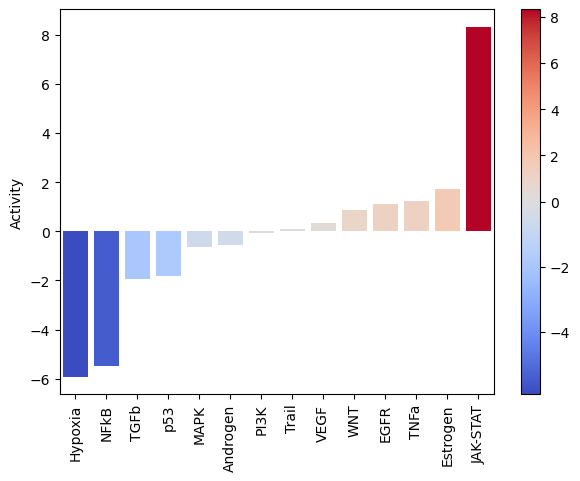

In [5]:
dc.plot_barplot(pathway_acts, 'T cell', top=25, vertical=False)

It looks like JAK-STAT, a known immunity pathway is more active in T cells from COVID-19 patients than in controls. To further explore how the target genes of a pathway of interest behave, we can plot them in scatter plot:

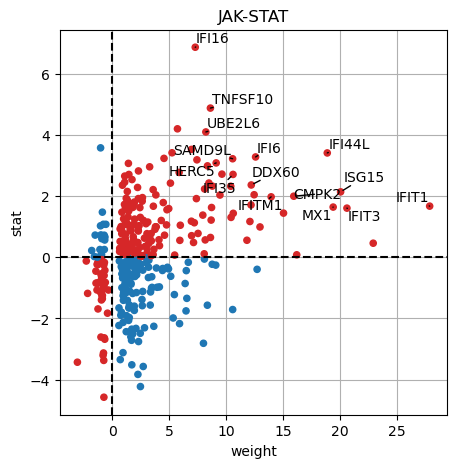

In [6]:
dc.plot_targets(results_df, stat='stat', source_name='JAK-STAT', net=progeny, top=15)

The observed activation of JAK-STAT is due to the fact that majority of its target genes with positive weights have positive t-values (1st quadrant), and the majority of the ones with negative weights have negative t-values (3d quadrant).